In [143]:
import pandas as pd 
import numpy as np 
from utils import * 
from src import get_genome_id
import os
from src.files import FASTAFile, InterProScanFile, GBFFFile
import subprocess
import glob
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
ref_df = load_ref(add_labels=True)

In [196]:
has_hit = lambda df : (df.reason == 'needs manual validation')
has_no_hit = lambda df : (df.reason == 'no InterProScan hit')
has_antifam_hit = lambda df: (df.reason == 'AntiFam InterProScan hit')

is_intergenic_no_hit = lambda df : has_no_hit(df) & (df.category == 'intergenic')
is_intergenic_hit = lambda df : has_hit(df) & (df.category == 'intergenic')
is_conflict_no_hit = lambda df : has_no_hit(df) & (df.category == 'conflict')
is_conflict_hit = lambda df : has_hit(df) & (df.category == 'conflict')  

is_spurious = lambda df : df.label == 'spurious'

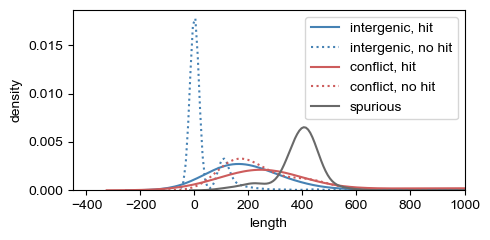

In [210]:
def figure_1(ref_df:pd.DataFrame, max_length:int=1000):
    ref_df = ref_df[ref_df.reason != 'suspect top hit'].copy()
    ref_df = ref_df[ref_df.query_length // 3 < max_length].copy()

    fig = plt.figure(figsize=(5, 2.5), layout='tight')
    ax = fig.add_subplot()

    colors = ['steelblue', 'steelblue', 'indianred', 'indianred', 'dimgray']
    linestyles = ['-', ':', '-', ':', '-']
    categories = ['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'spurious']
    masks = [is_intergenic_hit(ref_df), is_intergenic_no_hit(ref_df), is_conflict_hit(ref_df), is_conflict_no_hit(ref_df), is_spurious(ref_df)]

    ax_df = ref_df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[ax_df.category != 'none'].copy()
    ax_df = ax_df[['category', 'query_length']]
    ax_df = ax_df.rename(columns={'query_length':'length'})

    for category, color, linestyle in zip(categories, colors, linestyles):
        sns.kdeplot(data=ax_df[ax_df.category == category], x='length', ax=ax, linewidth=1.5, linestyle=linestyle, color=color, label=category, common_norm=False)
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlim(xmax=1000)
    plt.show()

figure_1(ref_df)


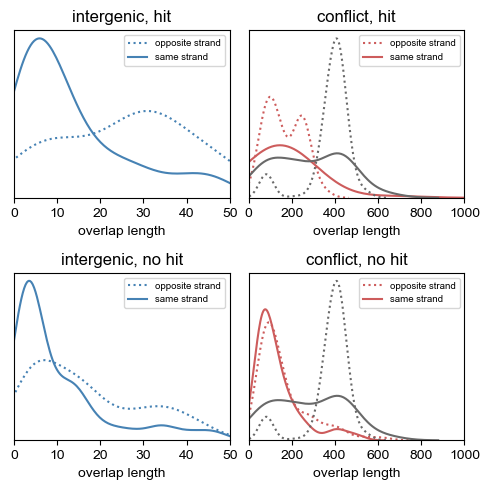

In [209]:
# What fraction of the overlaps with hits are on the same strand?
# Conflict overlaps can be on the same strand, just won't be in-frame. 
# Want to characterize the overlaps and length profiles of the different categories. 
# Are there any patterns in what can or cannot be labeled?
# What are the differences in the overlap profiles for hits on the same or opposite strands?

def figure_2(ref_df:pd.DataFrame, max_length:int=1000, overlap_metric='overlap_length'):
    ref_df = ref_df[ref_df.reason != 'suspect top hit'].copy()
    ref_df = ref_df[ref_df.query_length // 3 < max_length].copy()

    fig = plt.figure(figsize=(5, 5), layout='tight')
    grid = GridSpec(figure=fig, nrows=2, ncols=2, width_ratios=[0.5, 0.5])
    ax = list()
    ax.append(fig.add_subplot(grid[0, 0], xlim=(0, 50)))
    ax.append(fig.add_subplot(grid[1, 0], sharex=ax[-1]))
    ax.append(fig.add_subplot(grid[0, 1], xlim=(0, 1000)))
    ax.append(fig.add_subplot(grid[1, 1], sharex=ax[-1]))

    colors = ['steelblue', 'steelblue', 'indianred', 'indianred']
    categories = ['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'spurious']
    masks = [is_intergenic_hit(ref_df), is_intergenic_no_hit(ref_df), is_conflict_hit(ref_df), is_conflict_no_hit(ref_df), is_spurious(ref_df)]

    ax_df = ref_df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[ax_df.category != 'none'].copy()
    ax_df = ax_df[['category', overlap_metric, 'same_strand']]
    ax_df = ax_df[ax_df[overlap_metric] > 0].copy() # Only looking at intergenic hits with some overlap. 
    ax_df = ax_df.rename(columns={overlap_metric:overlap_metric.replace('_', ' ')})
    overlap_metric = overlap_metric.replace('_', ' ')

    for ax_, category, color in zip(ax, categories[:-1], colors):
        df_ = ax_df[ax_df.category == category]
        sns.kdeplot(data=df_[~df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle=':', color=color, label='opposite strand', common_norm=False)
        sns.kdeplot(data=df_[df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle='-', color=color, label='same strand', common_norm=False)
        ax_.set_title(category, fontsize='large')
        ax_.set_yticks([])
        ax_.set_ylabel('')
        ax_.legend(fontsize='x-small')
        ax_.set_xlabel(overlap_metric)

    for ax_ in ax[2:]:
        df_ = ax_df[ax_df.category == 'spurious']
        sns.kdeplot(data=df_[~df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle=':', color='dimgray',  common_norm=False)
        sns.kdeplot(data=df_[df_.same_strand], x=overlap_metric, ax=ax_, linewidth=1.5, linestyle='-', color='dimgray',  common_norm=False) 

    plt.show()

figure_2(ref_df)

# The only thing separating a conflict from intergenic is the overlap threshold.

# I wonder what fraction of the things with no hits overlap with non-CDS things, like RNA genes.  

# Intergenic sequences must have less than 50bp overlap. This overlap can occur with (1) psuedogenes on the opposite strand, (2)
# non-pseudogenes that are not in-frame, (3) non-CDS sequences.
 

# Conflict sequences must have more than 50bp overlap. This overlap can occur with (1) psuedogenes on the opposite strand, (2)
# non-pseudogenes that are not in-frame, (3) non-CDS sequences. 

figure_2: Discarding 1771 intergenic sequences with no overlap.


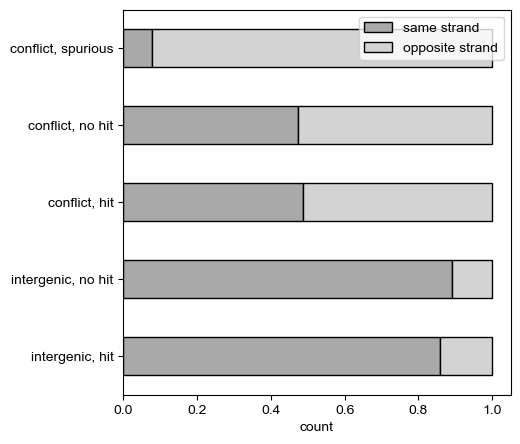

In [212]:
def figure_2(ref_df:pd.DataFrame, normalize:bool=True):
    ref_df = ref_df[ref_df.category.isin(['intergenic', 'conflict'])].copy()
    print(f'figure_2: Discarding {(ref_df.overlap_length > 0).sum()} intergenic sequences with no overlap.')
    ref_df = ref_df[ref_df.overlap_length > 0].copy()

    fig = plt.figure(figsize=(5, 5))
    # ax = fig.add_subplot(xlim=(0, 350))
    ax = fig.add_subplot()

    categories = np.array(['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'conflict, spurious'])
    masks = [is_intergenic_hit(ref_df), is_intergenic_no_hit(ref_df), is_conflict_hit(ref_df), is_conflict_no_hit(ref_df), is_spurious(ref_df)]

    ax_df = pd.DataFrame(columns=['same strand', 'opposite strand'], index=categories)
    for category, mask in zip(categories, masks):
        df_ = ref_df[mask]
        ax_df.loc[category, 'same strand'] = df_.same_strand.sum()
        ax_df.loc[category, 'opposite strand'] = ((df_.n_hits > 0) & (~df_.same_strand)).sum()

    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)
    ax_df.plot(kind='barh', stacked=True, color=['darkgray', 'lightgray'], ax=ax, edgecolor='black')
    ax.set_xlabel('count')

    plt.show()

figure_2(ref_df)


figure_3: Discarding 1771 intergenic sequences with no overlap.


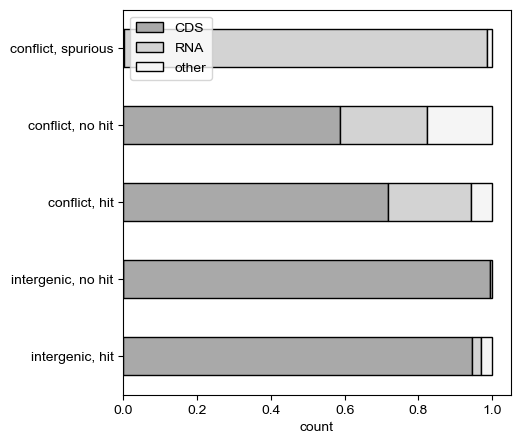

In [211]:
def figure_3(ref_df:pd.DataFrame, normalize:bool=True):
    ref_df = ref_df[ref_df.category.isin(['intergenic', 'conflict'])].copy()
    print(f'figure_3: Discarding {(ref_df.overlap_length > 0).sum()} intergenic sequences with no overlap.')
    ref_df = ref_df[ref_df.overlap_length > 0].copy()
    

    fig = plt.figure(figsize=(5, 5))
    # ax = fig.add_subplot(xlim=(0, 350))
    ax = fig.add_subplot()

    categories = np.array(['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit', 'conflict, spurious'])
    masks = [is_intergenic_hit(ref_df), is_intergenic_no_hit(ref_df), is_conflict_hit(ref_df), is_conflict_no_hit(ref_df), is_spurious(ref_df)]

    ax_df = pd.DataFrame(columns=['CDS', 'RNA', 'other'], index=categories)
    for category, mask in zip(categories, masks):
        df = ref_df[mask]
        ax_df.loc[category, 'CDS'] = df.top_hit_feature.isin(GBFFFile.coding_features).sum()
        ax_df.loc[category, 'RNA'] = df.top_hit_feature.isin(GBFFFile.rna_features).sum()
        ax_df.loc[category, 'other'] = df.top_hit_feature.isin(GBFFFile.other_features).sum()

    if normalize:
        ax_df = ax_df / ax_df.values.sum(axis=1).reshape(-1, 1)

    ax_df.plot(kind='barh', stacked=True, color=['darkgray', 'lightgray', 'whitesmoke'], ax=ax, edgecolor='black')
    ax.set_xlabel('count')

    plt.show()

figure_3(ref_df)

# Things to consider: strand, what is being overlapped with, whether or not it has an InterProScan hit.
# What am I actually trying to find out? Trying to characterize what spurious sequences might look like based on the ones 
# identified with AntiFam. I think the most likely candidate are the conflict, no hits with overlapping RNA features, so want to characterize those more.